# IE6511 Homework 7
Done by: Aloisius Stephen and Yang Xiaozhou

In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pySOT import *
from poap.controller import SerialController, ThreadController, BasicWorkerThread
from pySOT import Ackley, SyncStrategyNoConstraints, \
    SymmetricLatinHypercube, RBFInterpolant, CubicKernel, \
    LinearTail, CandidateDYCORS

%matplotlib inline

np.set_printoptions(precision=3)

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

## 1. Performances of DDS, LMSRBF (PySOT) and G-MSRBF (PySOT) on the “Ackley” function, within a limited evaluation budget 

### (a) DDS

In [10]:
data = Ackley(dim=20)
trial = 20
maxeval = 200

DDS function taken from HW4

In [11]:
def DDS(x_min,x_max,m,x_initial):
    r=0.2
    sBest=x_initial
    sCur=x_initial
    CostBest=data.objfunction(sBest)
    dimen=np.size(x_initial)
    Cost_iter = np.zeros(m)
    Iter = np.zeros(m)
    x_range=x_max-x_min
    k=0
    
    for i in range(0,m):
        sCur=sBest
        Iter[i] = np.int(i+1)
        Cost_iter[i]=CostBest
        for j in range(0,dimen):
            if (np.random.rand(1)<(1-(np.log(i+1)/np.log(m+1)))):
                k=k+1
                sCur[j]=sBest[j]+np.random.randn(1,1)*r*(x_range)
                if(sCur[j]<x_min):
                    sCur[j]=x_min+(x_min-sCur[j])
                    if(sCur[j]>x_max):
                        sCur[j]=x_min
                        
                if(sCur[j]>x_max):
                    sCur[j]=x_max-(sCur[j]-x_max)
                    if(sCur[j]<x_min):
                        sCur[j]=x_max
        
            if(k==0):
                index=np.random.randint(0,dimen)
                sCur[index]=sBest[index]+np.random.randn(1,1)*r*(x_range)
                if(sCur[index]<x_min):
                    sCur[index]=x_min+(x_min-sCur[index])
                    if(sCur[index]>x_max):
                        sCur[index]=x_min
                            
                if(sCur[index]>x_max):
                    sCur[index]=x_max-(sCur[index]-x_max)
                    if(sCur[index]<x_min):
                        sCur[index]=x_max
            k=0
            
            # Update sBest and CostBest if sCur has lower cost
            if(data.objfunction(sCur)<CostBest):
                sBest=sCur
                CostBest=data.objfunction(sBest)
    sol = pd.DataFrame(np.column_stack((Iter,Cost_iter)), columns = ['Iteration','Cost'])
    return sol 

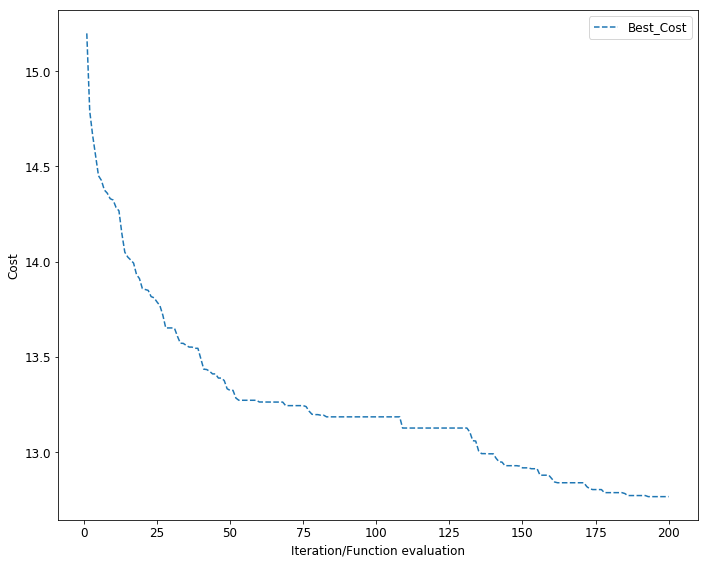

In [12]:
x_init = 10*np.random.rand(data.dim)

Trial_best_DDS = DDS(0,10,maxeval,x_init)

for i  in range(1,trial):
    Trial_best_DDS = Trial_best_DDS.append(DDS(0,10,maxeval,x_init))

# Average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_DDS.groupby('Iteration').mean().Cost, '--')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost'])
plt.tight_layout()

### (b) LMSRBF

In [13]:
print("\nMethod: LMSRBF")
print("Number of threads: 4")
print("Maximum number of evaluations: 200")
print("Sampling method: CandidateSRBF")
print("Experimental design: Symmetric Latin Hypercube")
print("Surrogate: Cubic RBF")

nthreads = 4
nsamples = nthreads

print(data.info)

# Create a strategy and a controller
controller = ThreadController()
controller.strategy = \
    SyncStrategyNoConstraints(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=nsamples,
        exp_design=SymmetricLatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail,
                                        maxp=maxeval),
        sampling_method=CandidateSRBF(data=data, numcand=100*data.dim))

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()
fvals = np.array([o.value for o in controller.fevals])

Iter = np.arange(1,maxeval+1)
Trial_best_LMSRBF = np.column_stack((Iter,np.minimum.accumulate(fvals)))

# Run the rest of the trials 
for i  in range(1,trial):
    # Create a strategy and a controller
    controller = ThreadController()
    controller.strategy = \
        SyncStrategyNoConstraints(
            worker_id=0, data=data,
            maxeval=maxeval, nsamples=nsamples,
            exp_design=SymmetricLatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
            response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail,
                                            maxp=maxeval),
            sampling_method=CandidateSRBF(data=data, numcand=100*data.dim))

    # Launch the threads and give them access to the objective function
    for _ in range(nthreads):
        worker = BasicWorkerThread(controller, data.objfunction)
        controller.launch_worker(worker)
        
    result = controller.run()
    fvals = np.array([o.value for o in controller.fevals])
    Trial_best_LMSRBF = np.concatenate((Trial_best_LMSRBF, 
                                        np.column_stack((Iter,np.minimum.accumulate(fvals)))), axis=0)
    
    
Trial_best_LMSRBF_df = pd.DataFrame(Trial_best_LMSRBF, columns = ['Iteration','Cost'])


Method: LMSRBF
Number of threads: 4
Maximum number of evaluations: 200
Sampling method: CandidateSRBF
Experimental design: Symmetric Latin Hypercube
Surrogate: Cubic RBF
20-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


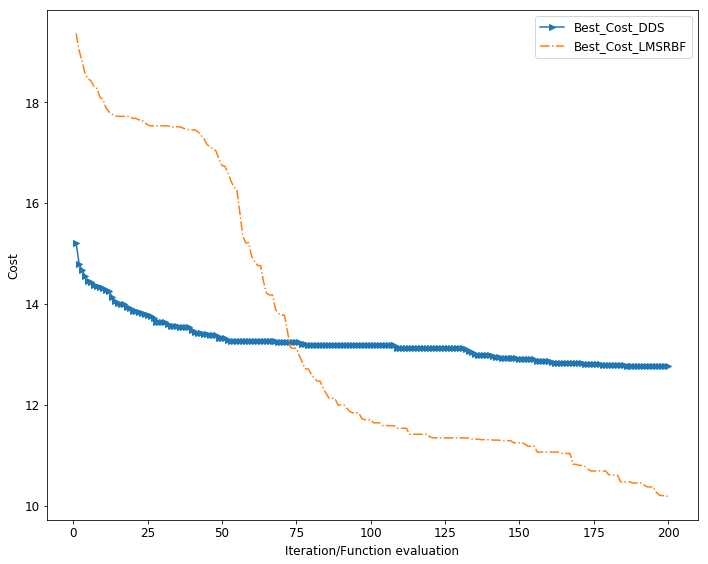

In [14]:
# Average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_DDS.groupby('Iteration').mean().Cost, '->')
plt.plot(Trial_best_LMSRBF_df.groupby('Iteration').mean().Cost, '-.')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost_DDS', 'Best_Cost_LMSRBF'])
plt.tight_layout()

### (c) G-MSRBF

In [15]:
print("\nMethod: G-MSRBF")
print("Number of threads: 4")
print("Maximum number of evaluations: 200")
print("Sampling method: CandidateUniform")
print("Experimental design: Symmetric Latin Hypercube")
print("Surrogate: Cubic RBF")


# Create a strategy and a controller

# Cycling through weights when sampling
sampling_methods = [CandidateUniform(data=data, numcand=100*data.dim, weights=[0.2, 0.8]), \
                    CandidateUniform(data=data, numcand=100*data.dim, weights=[0.4, 0.6]), \
                    CandidateUniform(data=data, numcand=100*data.dim, weights=[0.6, 0.4]), \
                    CandidateUniform(data=data, numcand=100*data.dim, weights=[0.9, 0.1]), \
                    CandidateUniform(data=data, numcand=100*data.dim, weights=[0.95, 0.05]), \
                    CandidateUniform(data=data, numcand=100*data.dim, weights=[1, 0])]
cycle = [0, 1, 2, 3, 4, 5]
sampling_methods = MultiSampling(sampling_methods, cycle)


controller = ThreadController()
controller.strategy = \
    SyncStrategyNoConstraints(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=nsamples,
        exp_design=SymmetricLatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail,
                                        maxp=maxeval),
        sampling_method=sampling_methods)

    

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()
fvals = np.array([o.value for o in controller.fevals])

Iter = np.arange(1,maxeval+1)
Trial_best_GMSRBF = np.column_stack((Iter,np.minimum.accumulate(fvals)))

# Run the rest of the trials 
for i  in range(1,trial):
    controller = ThreadController()
    controller.strategy = \
        SyncStrategyNoConstraints(
            worker_id=0, data=data,
            maxeval=maxeval, nsamples=nsamples,
            exp_design=SymmetricLatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
            response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail,
                                            maxp=maxeval),
            sampling_method=sampling_methods)

# Launch the threads and give them access to the objective function
    for _ in range(nthreads):
        worker = BasicWorkerThread(controller, data.objfunction)
        controller.launch_worker(worker)

    result = controller.run()
    fvals = np.array([o.value for o in controller.fevals])
    Trial_best_GMSRBF = np.concatenate((Trial_best_GMSRBF, 
                                        np.column_stack((Iter,np.minimum.accumulate(fvals)))), axis=0)
    
Trial_best_GMSRBF_df = pd.DataFrame(Trial_best_GMSRBF, columns = ['Iteration','Cost'])


Method: G-MSRBF
Number of threads: 4
Maximum number of evaluations: 200
Sampling method: CandidateUniform
Experimental design: Symmetric Latin Hypercube
Surrogate: Cubic RBF


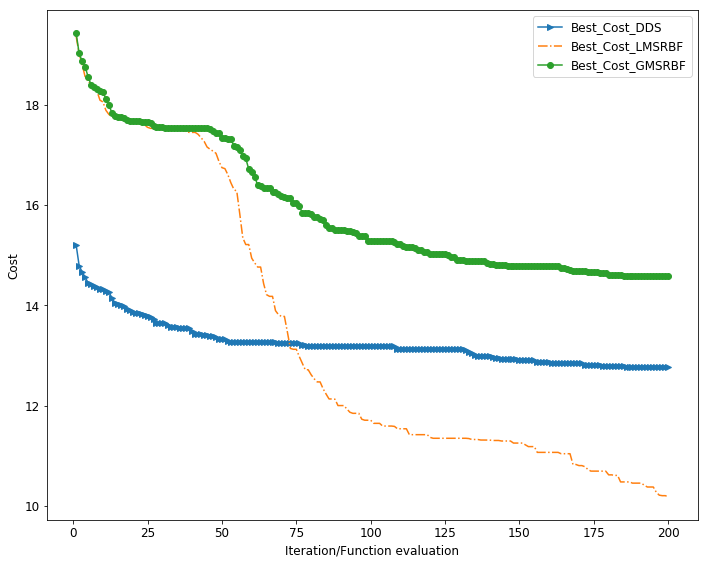

In [16]:
# Average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_DDS.groupby('Iteration').mean().Cost, '->')
plt.plot(Trial_best_LMSRBF_df.groupby('Iteration').mean().Cost, '-.')
plt.plot(Trial_best_GMSRBF_df.groupby('Iteration').mean().Cost, '-o')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost_DDS', 'Best_Cost_LMSRBF', 'Best_Cost_GMSRBF'])
plt.tight_layout()

#### From just looking at the plot, does it appear as if one algorithm dominates the others?
Yes, it seems like LMSRBF dominates the other two algorithms. 

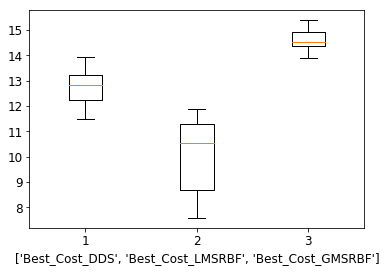

In [17]:
plt.boxplot([Trial_best_DDS[Trial_best_DDS['Iteration'] == 200].Cost.values, 
             Trial_best_LMSRBF_df[Trial_best_LMSRBF_df['Iteration'] == 200].Cost.values,
            Trial_best_GMSRBF_df[Trial_best_GMSRBF_df['Iteration'] == 200].Cost.values])
plt.xlabel(['Best_Cost_DDS', 'Best_Cost_LMSRBF', 'Best_Cost_GMSRBF'])
pass

The test result is consistent with the previous conclusion. 

## 2.	Using PySOT with different Surrogate Models on the “Ackley” Function (10 points)

### (a) CRBF-LMSRBF

In [28]:
print("\nMethod: CRBF-LMSRBF")
print("Number of threads: 4")
print("Maximum number of evaluations: 500")
print("Sampling method: CandidateSRBF")
print("Experimental design: Symmetric Latin Hypercube")
print("Surrogate: Cubic RBF")

data = Ackley(dim=15)
trial = 20
maxeval = 500

nthreads = 4
nsamples = nthreads

print(data.info)

# Create a strategy and a controller
controller = ThreadController()
controller.strategy = \
    SyncStrategyNoConstraints(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=nsamples,
        exp_design=SymmetricLatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail,
                                        maxp=maxeval),
        sampling_method=CandidateSRBF(data=data, numcand=100*data.dim))

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()
fvals = np.array([o.value for o in controller.fevals])

Iter = np.arange(1,maxeval+1)
Trial_best_CRBF_LMSRBF = np.column_stack((Iter,np.minimum.accumulate(fvals)))

# Run the rest of the trials 
for i  in range(1,trial):
    # Create a strategy and a controller
    controller = ThreadController()
    controller.strategy = \
        SyncStrategyNoConstraints(
            worker_id=0, data=data,
            maxeval=maxeval, nsamples=nsamples,
            exp_design=SymmetricLatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
            response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail,
                                            maxp=maxeval),
            sampling_method=CandidateSRBF(data=data, numcand=100*data.dim))

    # Launch the threads and give them access to the objective function
    for _ in range(nthreads):
        worker = BasicWorkerThread(controller, data.objfunction)
        controller.launch_worker(worker)

    result = controller.run()
    fvals = np.array([o.value for o in controller.fevals])
    Trial_best_CRBF_LMSRBF = np.concatenate((Trial_best_CRBF_LMSRBF, 
                                        np.column_stack((Iter,np.minimum.accumulate(fvals)))), axis=0)
    
Trial_best_CRBF_LMSRBF_df = pd.DataFrame(Trial_best_CRBF_LMSRBF, columns = ['Iteration','Cost'])


Method: CRBF-LMSRBF
Number of threads: 4
Maximum number of evaluations: 500
Sampling method: CandidateSRBF
Experimental design: Symmetric Latin Hypercube
Surrogate: Cubic RBF
15-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


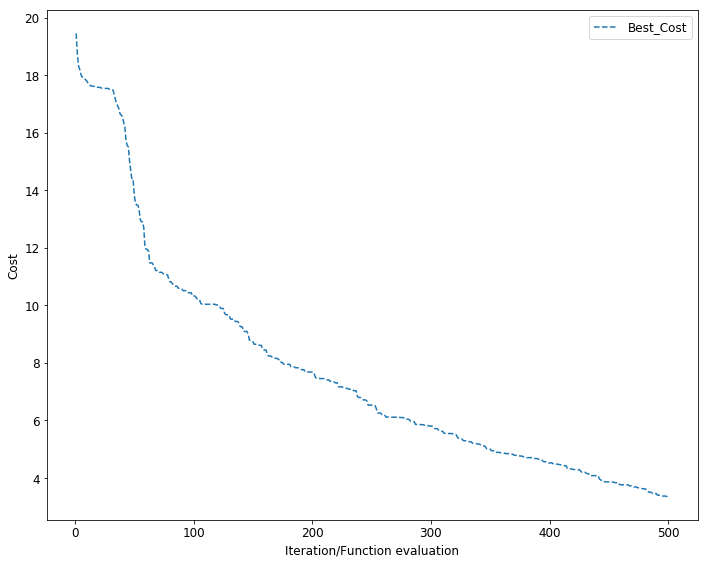

In [29]:
# Average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_CRBF_LMSRBF_df.groupby('Iteration').mean().Cost, '--')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost'])
plt.tight_layout()

### (b) LRBF-LMSRBF

In [30]:
print("\nMethod: LRBF-LMSRBF")
print("Number of threads: 4")
print("Maximum number of evaluations: 500")
print("Sampling method: CandidateSRBF")
print("Experimental design: Symmetric Latin Hypercube")
print("Surrogate: Linear RBF")


print(data.info)

# Create a strategy and a controller
controller = ThreadController()
controller.strategy = \
    SyncStrategyNoConstraints(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=nsamples,
        exp_design=SymmetricLatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        response_surface=RBFInterpolant(kernel=LinearKernel, tail=LinearTail,
                                        maxp=maxeval),
        sampling_method=CandidateSRBF(data=data, numcand=100*data.dim))

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()
fvals = np.array([o.value for o in controller.fevals])

Iter = np.arange(1,maxeval+1)
Trial_best_LRBF_LMSRBF = np.column_stack((Iter,np.minimum.accumulate(fvals)))

# Run the rest of the trials 
for i  in range(1,trial):
    # Create a strategy and a controller
    controller = ThreadController()
    controller.strategy = \
        SyncStrategyNoConstraints(
            worker_id=0, data=data,
            maxeval=maxeval, nsamples=nsamples,
            exp_design=SymmetricLatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
            response_surface=RBFInterpolant(kernel=LinearKernel, tail=LinearTail,
                                            maxp=maxeval),
            sampling_method=CandidateSRBF(data=data, numcand=100*data.dim))

    # Launch the threads and give them access to the objective function
    for _ in range(nthreads):
        worker = BasicWorkerThread(controller, data.objfunction)
        controller.launch_worker(worker)
   
    result = controller.run()
    fvals = np.array([o.value for o in controller.fevals])
    Trial_best_LRBF_LMSRBF = np.concatenate((Trial_best_LRBF_LMSRBF, 
                                        np.column_stack((Iter,np.minimum.accumulate(fvals)))), axis=0)
    
Trial_best_LRBF_LMSRBF_df = pd.DataFrame(Trial_best_LRBF_LMSRBF, columns = ['Iteration','Cost'])


Method: LRBF-LMSRBF
Number of threads: 4
Maximum number of evaluations: 500
Sampling method: CandidateSRBF
Experimental design: Symmetric Latin Hypercube
Surrogate: Linear RBF
15-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


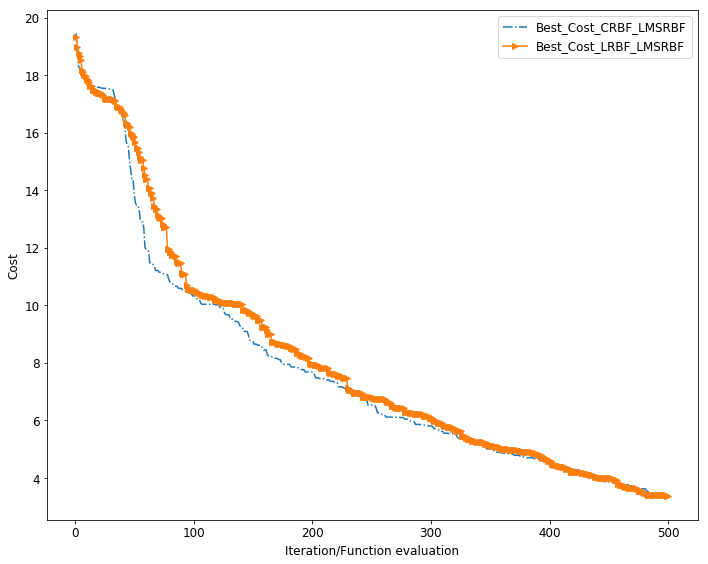

In [31]:
# Average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_CRBF_LMSRBF_df.groupby('Iteration').mean().Cost, '-.')
plt.plot(Trial_best_LRBF_LMSRBF_df.groupby('Iteration').mean().Cost, '->')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost_CRBF_LMSRBF', 'Best_Cost_LRBF_LMSRBF'])
plt.tight_layout()

### (c)
Discussion: LRBF_LMSRBF performs slightly better than CRBF_LMSRBF towards the later part of iteration, but the different is not significant. This is probably because of the high complexity of the Ackley function, i.e. a large number of local minima, that neither linear nor cubic RBF is significantly better at approximating the function than each other. 

## 3.	What are the differences between Global Metric RBF and Local Metric RBF in Regis and Shoemaker (2007)?  Give a succinct list of the ways in which they are different. (5 points)	

Differences: <br>
1. **Candidate points generation:** <br>
    For Global Metric RBF the set of candidate points are generated uniformly at random throughout the domain. <br>
    Under the Local Metric RBF the set of candidate points are generated by adding random perturbation to all the coordinates of the current best solution.
    
2. **Global search:** <br>
    Global Metric RBF carries this out by having a high weight for the distance criterion at the start of its weight cycle. <br> 
    Local Metric RBF does this by having a restart, which is achieved through reinitializing with a different experimental design when the number of consecutive failed iterations exceed a threshold parameter.

## 4.	Using PySOT with different Surrogate Models on the “Ackley” Function (10 points)

### (d) CRBF-DYCORS

In [24]:
print("\nMethod: CRBF-DYCORS")
print("Number of threads: 1")
print("Maximum number of evaluations: 500")
print("Sampling method: CandidateDYCORS")
print("Experimental design: Latin Hypercube")
print("Surrogate: Cubic RBF")

data = Ackley(dim=15)
trial = 10
maxeval = 500

nthreads = 1
nsamples = nthreads

print(data.info)

# Create a strategy and a controller
controller = ThreadController()
controller.strategy = \
    SyncStrategyNoConstraints(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=nsamples,
        exp_design=LatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail,
                                        maxp=maxeval),
        sampling_method=CandidateDYCORS(data=data, numcand=100*data.dim))

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()
fvals = np.array([o.value for o in controller.fevals])

Iter = np.arange(1,maxeval+1)
Trial_best_CRBF_DYCORS = np.column_stack((Iter,np.minimum.accumulate(fvals)))

# Run the rest of the trials 
for i  in range(1,trial):
    # Create a strategy and a controller
    controller = ThreadController()
    controller.strategy = \
        SyncStrategyNoConstraints(
            worker_id=0, data=data,
            maxeval=maxeval, nsamples=nsamples,
            exp_design=LatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
            response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail,
                                            maxp=maxeval),
            sampling_method=CandidateDYCORS(data=data, numcand=100*data.dim))

    # Launch the threads and give them access to the objective function
    for _ in range(nthreads):
        worker = BasicWorkerThread(controller, data.objfunction)
        controller.launch_worker(worker)
    
    result = controller.run()
    fvals = np.array([o.value for o in controller.fevals])
    Trial_best_CRBF_DYCORS = np.concatenate((Trial_best_CRBF_DYCORS, 
                                        np.column_stack((Iter,np.minimum.accumulate(fvals)))), axis=0)
    
Trial_best_CRBF_DYCORS_df = pd.DataFrame(Trial_best_CRBF_DYCORS, columns = ['Iteration','Cost'])


Method: CRBF-DYCORS
Number of threads: 1
Maximum number of evaluations: 500
Sampling method: CandidateDYCORS
Experimental design: Latin Hypercube
Surrogate: Cubic RBF
15-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


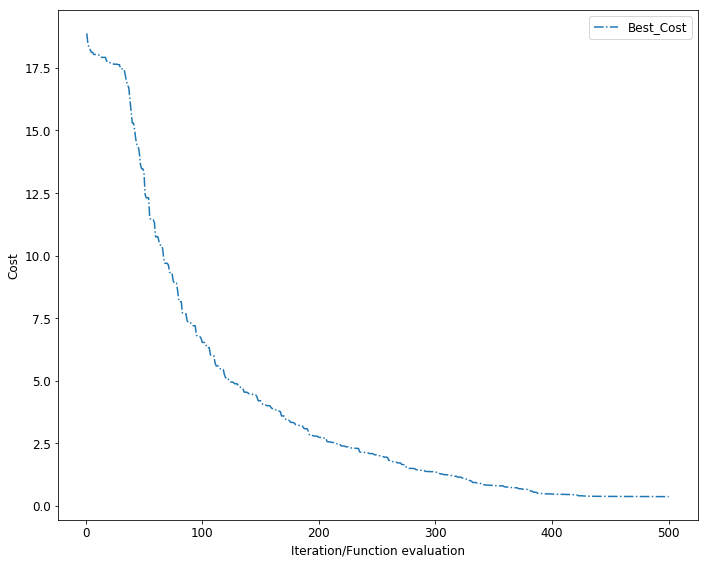

In [25]:
# Average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_CRBF_DYCORS_df.groupby('Iteration').mean().Cost, '-.')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost'])
plt.tight_layout()

### (e) LRBF-DYCORS

In [26]:
print("\nMethod: LRBF-DYCORS")
print("Number of threads: 1")
print("Maximum number of evaluations: 500")
print("Sampling method: CandidateDYCORS")
print("Experimental design: Latin Hypercube")
print("Surrogate: Linear RBF")

print(data.info)

# Create a strategy and a controller
controller = ThreadController()
controller.strategy = \
    SyncStrategyNoConstraints(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=nsamples,
        exp_design=LatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        response_surface=RBFInterpolant(kernel=LinearKernel, tail=LinearTail,
                                        maxp=maxeval),
        sampling_method=CandidateDYCORS(data=data, numcand=100*data.dim))

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()
fvals = np.array([o.value for o in controller.fevals])

Iter = np.arange(1,maxeval+1)
Trial_best_LRBF_DYCORS = np.column_stack((Iter,np.minimum.accumulate(fvals)))

# Run the rest of the trials 
for i  in range(1,trial):
    # Create a strategy and a controller
    controller = ThreadController()
    controller.strategy = \
        SyncStrategyNoConstraints(
            worker_id=0, data=data,
            maxeval=maxeval, nsamples=nsamples,
            exp_design=LatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
            response_surface=RBFInterpolant(kernel=LinearKernel, tail=LinearTail,
                                            maxp=maxeval),
            sampling_method=CandidateDYCORS(data=data, numcand=100*data.dim))

    # Launch the threads and give them access to the objective function
    for _ in range(nthreads):
        worker = BasicWorkerThread(controller, data.objfunction)
        controller.launch_worker(worker)
        
    result = controller.run()
    fvals = np.array([o.value for o in controller.fevals])
    Trial_best_LRBF_DYCORS = np.concatenate((Trial_best_LRBF_DYCORS, 
                                        np.column_stack((Iter,np.minimum.accumulate(fvals)))), axis=0)
    
Trial_best_LRBF_DYCORS_df = pd.DataFrame(Trial_best_LRBF_DYCORS, columns = ['Iteration','Cost'])


Method: LRBF-DYCORS
Number of threads: 1
Maximum number of evaluations: 500
Sampling method: CandidateDYCORS
Experimental design: Latin Hypercube
Surrogate: Linear RBF
15-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


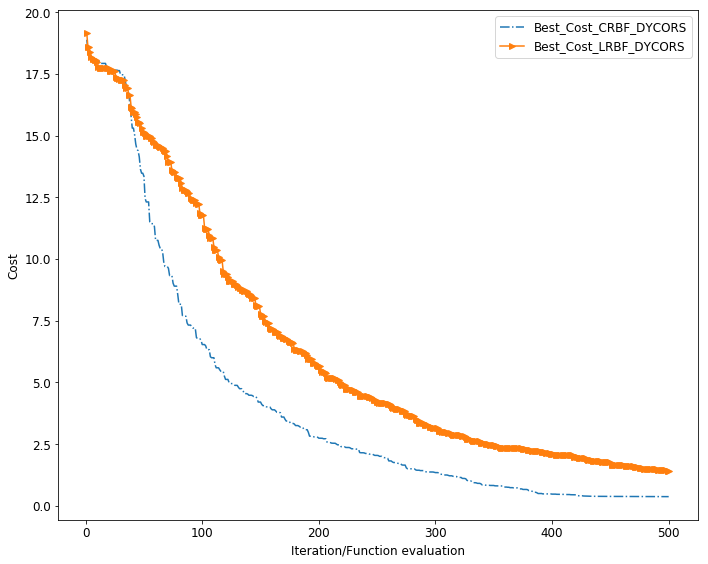

In [27]:
# Average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_CRBF_DYCORS_df.groupby('Iteration').mean().Cost, '-.')
plt.plot(Trial_best_LRBF_DYCORS_df.groupby('Iteration').mean().Cost, '->')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost_CRBF_DYCORS', 'Best_Cost_LRBF_DYCORS'])
plt.tight_layout()

### (f) 
Discussion: It seems like CRBF-DYCORS performs better than LRBF-DYCORS, the difference is more significant towards the end of the 500 iterations. This may be because that, with more evaluated points in the later stage, a cubic RBF approximates the Ackely function better than a linear RBF. 